 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import default_collate

from tqdm import notebook
from tqdm.auto import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from torchmetrics import Accuracy
acc = Accuracy()

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

print(torch.__version__)
import sys
sys.version

1.10.1+cu102


'3.8.12 (default, Dec 20 2021, 18:45:59) \n[GCC 11.1.0]'

Скачаем обучающую и контрольную выборки.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = tuple(str(i) for i in range(10))

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1. Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [ ]:
print(trainloader.dataset)
print(trainloader.dataset.data.shape)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
torch.Size([60000, 28, 28])


In [ ]:
targets_distribution = dict()
for target in trainloader.dataset.targets:
    target = target.item()
    if target not in targets_distribution:
        targets_distribution[target] = 1
    else:
        targets_distribution[target] += 1

In [ ]:
# Типы одежды распределены в одинаковых пропорциях
targets_distribution

{9: 6000,
 0: 6000,
 3: 6000,
 2: 6000,
 7: 6000,
 5: 6000,
 1: 6000,
 6: 6000,
 4: 6000,
 8: 6000}

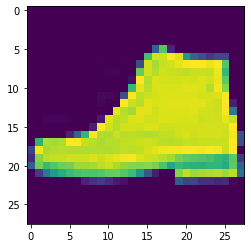

In [ ]:
plt.imshow(trainloader.dataset.data[42])

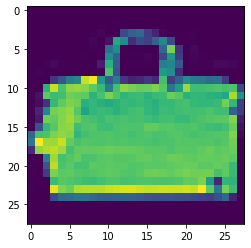

In [ ]:
plt.imshow(trainloader.dataset.data[99])

In [ ]:
class MLP(nn.Module):
    def __init__(self, h1=512, h2=512, in_=784, out=10): # 28*28=784
        super(MLP, self).__init__()
        self.in_ = in_
        self.dropout = nn.Dropout(0.2)
        self._0 = nn.Linear(in_, h1)
        self._1 = nn.ReLU()
        self._2 = nn.Linear(h1, h2)
        self._3 = nn.ReLU()
        self._4 = nn.Linear(h2, out)

    def forward(self, x):
        x = x.view(-1, self.in_)
        x = self._0(x)
        x = self._1(x)
        x = self.dropout(x)
        x = self._2(x)
        x = self._3(x)
        x = self.dropout(x)
        x = self._4(x)
        return x

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def fit(model, optimizer, criterion, epochs=40):
    loss_values = []
    accu_values = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        correctness = 0
        for images, labels in trainloader:
            images = images.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            
            output = model(images)
            correctness += acc(output.detach().cpu(), labels.detach().cpu()).item()
        loss_values.append(running_loss/len(trainloader.dataset))
        accu_values.append(correctness/len(trainloader.dataset))

#         print(f'Loss:{running_loss/len(trainloader.dataset)}\t\tAcc:{correctness/len(trainloader.dataset)}')
    return loss_values, accu_values

In [ ]:
def print_results(model):
    model.eval()
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            y_pred = model(images)
            _, predicted = torch.max(y_pred, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    res = []
    for i in range(10):
        res.append(100 * class_correct[i] / class_total[i])
        print('Accuracy of %5s : %2d %%' % (
            classes[i], res[-1]))
    print(f"Mean accuracy {sum(res) / len(res)}%")

In [ ]:
mlp_net = MLP()

mlp_net.cuda()
mlp_net.train()
next(mlp_net.parameters()).is_cuda

True

In [ ]:
cnn_net = CNN()

cnn_net.cuda()
cnn_net.train()
next(cnn_net.parameters()).is_cuda

True

In [ ]:
mlp_loss_fn = torch.nn.CrossEntropyLoss()
mlp_optimizer = torch.optim.NAdam(mlp_net.parameters(), lr=0.0001)

In [ ]:
%%time
mlp_loss_values, mlp_accu_values = fit(mlp_net, mlp_optimizer, mlp_loss_fn)

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 2h 41min 43s, sys: 57.7 s, total: 2h 42min 41s
Wall time: 27min 6s


In [ ]:
cnn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.NAdam(cnn_net.parameters(), lr=0.0001)

In [ ]:
%%time
cnn_loss_values, cnn_accu_values = fit(cnn_net, cnn_optimizer, cnn_loss_fn)

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 3h 47min 8s, sys: 1min 19s, total: 3h 48min 28s
Wall time: 38min 11s


# MLP results

In [ ]:
print_results(mlp_net)

Accuracy of     0 : 81 %
Accuracy of     1 : 98 %
Accuracy of     2 : 78 %
Accuracy of     3 : 90 %
Accuracy of     4 : 85 %
Accuracy of     5 : 96 %
Accuracy of     6 : 74 %
Accuracy of     7 : 98 %
Accuracy of     8 : 97 %
Accuracy of     9 : 94 %
Mean accuracy 89.61999999999999%


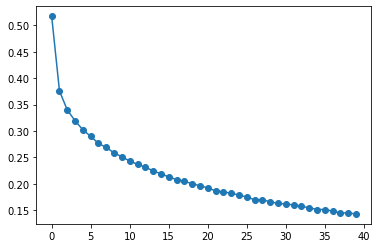

In [ ]:
plt.plot(mlp_loss_values, '-o')
plt.show()

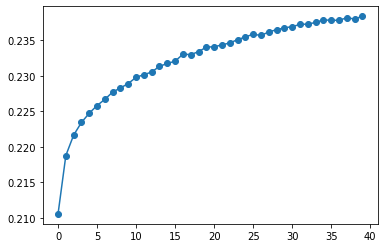

In [ ]:
plt.plot(mlp_accu_values, '-o')
plt.show()

# CNN results

In [ ]:
print_results(cnn_net)

Accuracy of     0 : 83 %
Accuracy of     1 : 97 %
Accuracy of     2 : 79 %
Accuracy of     3 : 87 %
Accuracy of     4 : 84 %
Accuracy of     5 : 97 %
Accuracy of     6 : 76 %
Accuracy of     7 : 96 %
Accuracy of     8 : 96 %
Accuracy of     9 : 95 %
Mean accuracy 89.47%


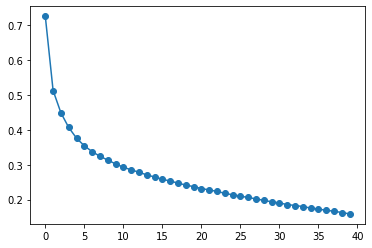

In [ ]:
plt.plot(cnn_loss_values, '-o')
plt.show()

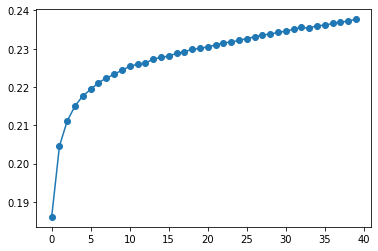

In [ ]:
plt.plot(cnn_accu_values, '-o')
plt.show()